# Chapter 11

## Load packages / modules

Standard library:
- Printf for string formatting

External:
- DataFrames.jl for tabular data
- CairoMakie.jl for plotting
- GLM.jl for models

In [1]:
using Printf
using DataFrames, CairoMakie, GLM

## Section 11.1

### Program 11.1

In [2]:
df1 = DataFrame(
    A = [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    Y = [
        200, 150, 220, 110, 50, 180, 90, 170,
        170, 30, 70, 110, 80, 50, 10, 20
    ]
);

Figure 11.1

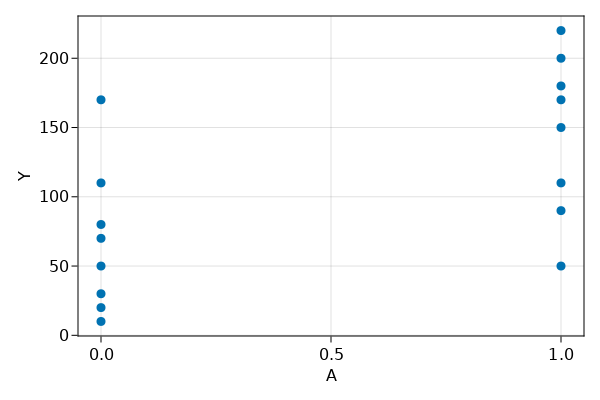

In [3]:
fig = Figure(resolution=(600, 400)) 
ax = Axis(fig[1, 1], xlabel="A", ylabel="Y")

scatter!(ax, df1[!, :A], df1[!, :Y])

fig

Summary of Y values grouped by A

In [4]:
grouped = groupby(df1, :A)
info = combine(describe, grouped)
info[info.variable .== :Y, :]

,A,variable,mean,min,median,max,nmissing,eltype
,Int64,Symbol,Float64,Int64,Float64,Int64,Int64,DataType
1,0,Y,67.5,10,60.0,170,0,Int64
2,1,Y,146.25,50,160.0,220,0,Int64


"Now suppose treatment A is a polytomous variable that can take 4 possible values"

In [5]:
df2 = DataFrame(
    A = [
        1, 1, 1, 1, 2, 2, 2, 2,
        3, 3, 3, 3, 4, 4, 4, 4
    ],
    Y = [
        110, 80, 50, 40, 170, 30, 70, 50,
        110, 50, 180, 130, 200, 150, 220, 210
    ]
);

Figure 11.2

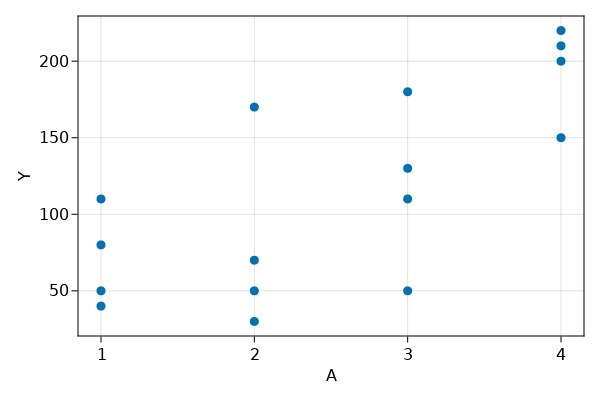

In [6]:
fig = Figure(resolution=(600, 400)) 
ax = Axis(fig[1, 1], xlabel="A", ylabel="Y")

scatter!(ax, df2[!, :A], df2[!, :Y])

fig

Summary of Y values grouped by A

In [7]:
grouped = groupby(df2, :A)
info = combine(describe, grouped)
info[info.variable .== :Y, :]

,A,variable,mean,min,median,max,nmissing,eltype
,Int64,Symbol,Float64,Int64,Float64,Int64,Int64,DataType
1,1,Y,70.0,40,65.0,110,0,Int64
2,2,Y,80.0,30,60.0,170,0,Int64
3,3,Y,117.5,50,120.0,180,0,Int64
4,4,Y,195.0,150,205.0,220,0,Int64


"Finally, suppose that treatment $A$ is a variable representing the dose of treatment in mg/day, and that it takes integer values from 0 to 100 mg."

In [8]:
AY = [
    [ 3,  21],
    [11,  54],
    [17,  33],
    [23, 101],
    [29,  85],
    [37,  65],
    [41, 157],
    [53, 120],
    [67, 111],
    [79, 200],
    [83, 140],
    [97, 220],
    [60, 230],
    [71, 217],
    [15,  11],
    [45, 190],
]

A = [row[1] for row in AY]
Y = [row[2] for row in AY];

Figure 11.3

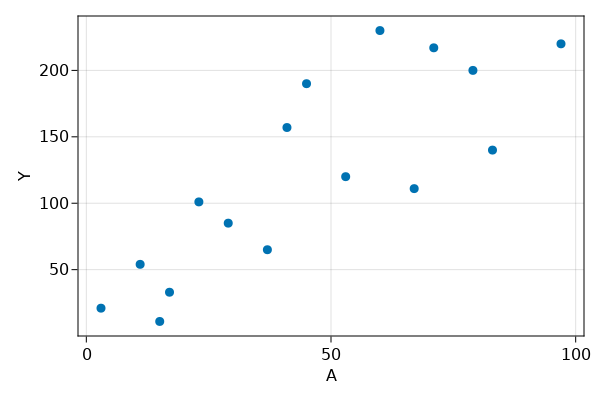

In [9]:
fig = Figure(resolution=(600, 400)) 
ax = Axis(fig[1, 1], xlabel="A", ylabel="Y")

scatter!(ax, A, Y)

fig

## Section 11.2

### Program 11.2

"The values $\hat{\theta}_0$ and $\hat{\theta}_1$ can be easily computed using linear algebra, as described in any statistics textbook."

Briefly, make $X$ be the matrix with ones in the first column and $A$ in the second column, and make $Y$ an $n \times 1$ matrix. Then $\hat{\theta}_0$ and $\hat{\theta}_1$ are calculated as $\hat\theta = (X^TX)^{-1}X^TY$

In [10]:
Xmat = [ones(length(A)) A]   # make X a matrix of ones and A values
Ymat = reshape(Y, :, 1)      # make Y an n x 1 matrix

theta = inv(Xmat' * Xmat) * Xmat' * Ymat

2×1 Matrix{Float64}:
 24.54636872082215
  2.137151984222771

In [11]:
@printf "θ₀ estimate:  %5.2f\nθ₁ estimate:  %5.2f" theta[1][1] theta[2][1]

θ₀ estimate:  24.55
θ₁ estimate:   2.14

In [12]:
expectation_at_90 = theta[1][1] + 90 * theta[2][1]
@printf "E[Y|A=90] estimate:  %5.1f" expectation_at_90

E[Y|A=90] estimate:  216.9

We can also compute this with a statistics modeling package like GLM.jl, which will give us confidence intervals and other values

In [13]:
df3 = DataFrame(A = A, Y = Y);

In [14]:
ols = lm(@formula(Y ~ A), df3)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

Y ~ 1 + A

Coefficients:
───────────────────────────────────────────────────────────────────────
                Coef.  Std. Error     t  Pr(>|t|)  Lower 95%  Upper 95%
───────────────────────────────────────────────────────────────────────
(Intercept)  24.5464    21.33      1.15    0.2691   -21.2019   70.2946
A             2.13715    0.399692  5.35    0.0001     1.2799    2.99441
───────────────────────────────────────────────────────────────────────

Prediction at A = 90 and confidence interval:

In [15]:
X_new = reshape([1 90], 1, 2)
y_info = predict(ols, X_new, interval=:confidence);

In [16]:
# unpack the prediction
y_pred = y_info[:prediction][1]
y_ci_1 = y_info[:lower][1]
y_ci_2 = y_info[:upper][1];

In [17]:
println("           estimate      95% C.I.")
@printf "E[Y|A=90]   %6.2f   (%6.2f, %6.2f)" y_pred y_ci_1 y_ci_2

           estimate      95% C.I.
E[Y|A=90]   216.89   (172.15, 261.63)

<br>
Figure 11.4

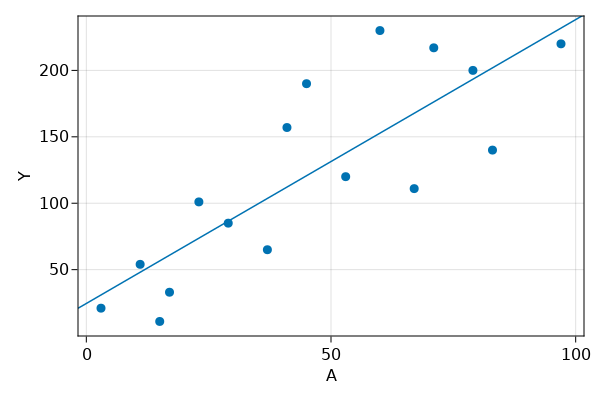

In [18]:
fig = Figure(resolution=(600, 400)) 
ax = Axis(fig[1, 1], xlabel="A", ylabel="Y")

scatter!(ax, A, Y)
abline!(ax, coef(ols)[1], coef(ols)[2])

fig

## Section 11.3

(Still Program 11.2)

"Let us return to the data in Figure 11.1."

In [19]:
ols = lm(@formula(Y ~ A), df1)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

Y ~ 1 + A

Coefficients:
────────────────────────────────────────────────────────────────────
             Coef.  Std. Error     t  Pr(>|t|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────
(Intercept)  67.5      19.7162  3.42    0.0041    25.213     109.787
A            78.75     27.8829  2.82    0.0135    18.9472    138.553
────────────────────────────────────────────────────────────────────

In [20]:
est_at_0 = coef(ols)[1]
est_at_1 = coef(ols)[1] + coef(ols)[2]
@printf "E[Y|A=0] est.: %6.2f\n" est_at_0
@printf "E[Y|A=1] est.: %6.2f" est_at_1

E[Y|A=0] est.:  67.50
E[Y|A=1] est.: 146.25

## Section 11.4

### Program 11.3

Starting from the same data as Section 11.2, Program 11.2

In [21]:
ols = lm(@formula(Y ~ A + A^2), df3)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

Y ~ 1 + A + :(A ^ 2)

Coefficients:
─────────────────────────────────────────────────────────────────────────────
                  Coef.  Std. Error      t  Pr(>|t|)    Lower 95%   Upper 95%
─────────────────────────────────────────────────────────────────────────────
(Intercept)  -7.40688    31.7478     -0.23    0.8192  -75.9938     61.18
A             4.10723     1.53088     2.68    0.0188    0.799962    7.41449
A ^ 2        -0.0203848   0.0153201  -1.33    0.2062   -0.0534817   0.0127122
─────────────────────────────────────────────────────────────────────────────

<br>
Figure 11.5

In [22]:
# values for the line
df3_sorted = sort(df3, :A)
X_fit = predict(ols, df3_sorted);

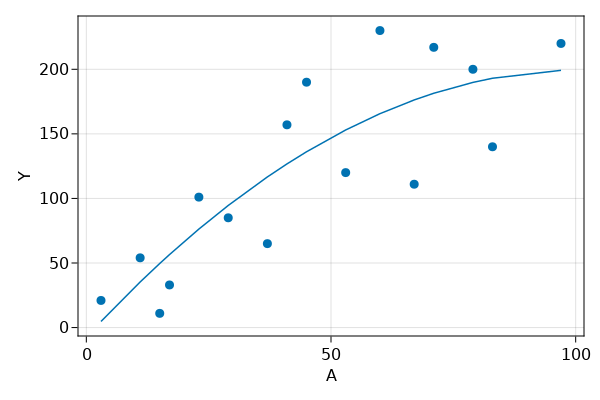

In [23]:
fig = Figure(resolution=(600, 400)) 
ax = Axis(fig[1, 1], xlabel="A", ylabel="Y")

scatter!(ax, df3.A, df3.Y)
lines!(ax, df3_sorted.A, X_fit)

fig

The expected value and confidence interval can be obtained the same way as above

In [24]:
X_new = reshape([1 90 90^2], 1, 3)
y_info = predict(ols, X_new, interval=:confidence);

In [25]:
y_pred = y_info[:prediction][1]
y_ci_1 = y_info[:lower][1]
y_ci_2 = y_info[:upper][1];

In [26]:
println("           estimate      95% C.I.")
@printf "E[Y|A=90]   %6.2f   (%6.2f, %6.2f)" y_pred y_ci_1 y_ci_2

           estimate      95% C.I.
E[Y|A=90]   197.13   (142.77, 251.49)